# Classification Prediction

Lets treat runtime prediction as a classification problem! Split the run times into 5 categories with equal amounts of training data and gather the data

In [909]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
import pandas as pd
import humanize
from datetime import datetime, timedelta
import time
import numpy as np
import seaborn as sns
import ast
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [910]:
CATEGORIES = [300, 1935, 3307, 11000, 260000]
N_BUCKETS = 5
N_FEATURES = 9

In [911]:
df = pd.read_csv("training_data.csv")
df = df.drop(columns=df.columns[0])
df.describe()

,runtime,sim_time,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,run_max_mem_rss_bytes,area,steps_fire
count,1567.000000,1567.000000,1567.000000,1567.00000,1567.000000,1567.000000,1567.000000,1.567000e+03,1.567000e+03,1567.00000
mean,6431.226548,8845.504786,0.132285,585.52074,146.346522,5.017888,0.865431,2.265994e+06,8.717648e+05,585.52074
std,6553.691660,6431.073029,0.066668,89.64333,86.238083,3.686380,0.240428,1.469066e+06,5.962585e+05,89.64333
min,10.000000,10.000000,0.000000,1.00000,-29.000000,1.000000,0.000000,4.011320e+05,2.948400e+05,1.00000
25%,1738.000000,4228.000000,0.090000,600.00000,90.000000,2.235000,0.900000,1.336916e+06,6.464160e+05,600.00000
50%,3086.000000,6084.000000,0.100000,600.00000,120.000000,4.470000,0.900000,2.462132e+06,6.480240e+05,600.00000
75%,10837.000000,11382.000000,0.200000,600.00000,210.000000,6.705000,1.000000,2.659250e+06,8.208640e+05,600.00000
max,53888.000000,88166.000000,0.330000,600.00000,360.000000,25.000000,1.200000,2.096308e+07,6.051040e+06,600.00000


Handy functions for later

In [912]:
def print_score(pred, true):
    print("Mean Squared Error:".ljust(22," "),round(mean_squared_error(true, pred),5))
    print("Mean Absolute Error:".ljust(22," "), round(mean_absolute_error(true, pred),5))
    
def convert(seconds):
    return humanize.naturaldelta(timedelta(seconds=seconds))

def show_diff(predictions,y_test,n=25):
    print("PREDICTION\t RESULT\t\t DIFFERENCE")
    print("-"*45)
    for i in range(0,n):
        print(predictions[i], "\t",y_test[i], "\t", y_test[i] - predictions[i])

def show_plots(predictions, y_test, s=4):
    plt.subplot(211)
    plt.title("Test Results and Predictions")
    plt.scatter(range(len(y_test)),y_test,s=s)
    plt.xlabel("X_test[i]")
    plt.ylabel("correct answer")
    plt.subplot(212)
    plt.scatter(range(len(predictions)),predictions,s=s)
    plt.ylabel("predictions")
    plt.show()

pred = {}
models = {}

## Remove Outliers from DataFrame
any simulations over 26000 seconds is what this just about works out to be

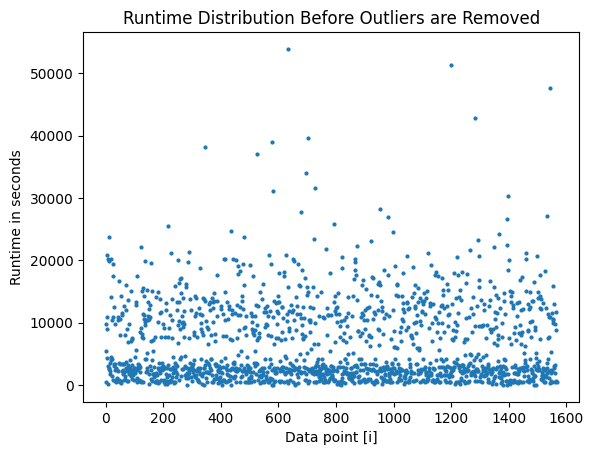

In [913]:
plt.title("Runtime Distribution Before Outliers are Removed")
plt.scatter(range(len(df["runtime"])),df["runtime"],s=4)
plt.ylabel("Runtime in seconds")
plt.xlabel("Data point [i]")
plt.show()

In [914]:
import pandas as pd
import numpy as np
from scipy import stats

df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [915]:
df.describe()

,runtime,sim_time,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,run_max_mem_rss_bytes,area,steps_fire
count,1442.000000,1442.000000,1442.000000,1442.0,1442.000000,1442.000000,1442.000000,1.442000e+03,1.442000e+03,1442.0
mean,6396.604022,9099.547850,0.132053,600.0,149.556865,4.700820,0.890187,2.198703e+06,8.645024e+05,600.0
std,5750.241251,5975.171672,0.066491,0.0,86.405921,2.921946,0.201519,1.134214e+06,5.494223e+05,0.0
min,10.000000,3699.000000,0.000000,600.0,-29.000000,1.000000,0.300000,4.011320e+05,2.948400e+05,600.0
25%,1935.000000,4503.000000,0.090000,600.0,90.000000,2.235000,0.900000,1.336937e+06,6.464160e+05,600.0
50%,3307.000000,6748.000000,0.100000,600.0,120.000000,4.470000,0.900000,2.461966e+06,6.480240e+05,600.0
75%,10958.250000,11382.000000,0.200000,600.0,225.000000,6.705000,1.000000,2.659110e+06,8.208640e+05,600.0
max,25866.000000,27251.000000,0.300000,600.0,360.000000,15.000000,1.200000,5.517084e+06,2.335392e+06,600.0


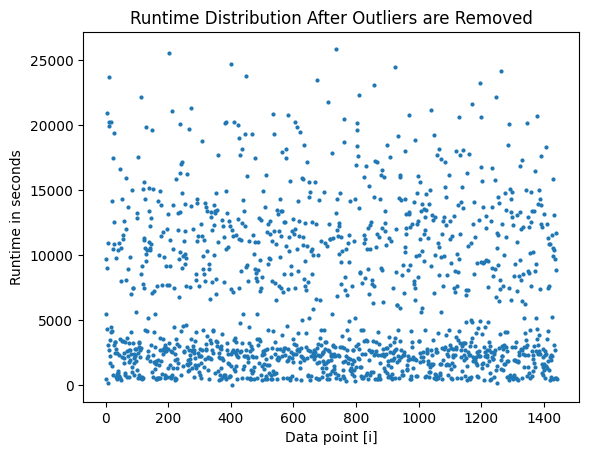

In [916]:
plt.title("Runtime Distribution After Outliers are Removed")
plt.scatter(range(len(df["runtime"])),df["runtime"],s=4)
plt.ylabel("Runtime in seconds")
plt.xlabel("Data point [i]")
plt.show()

<Axes: xlabel='runtime', ylabel='Count'>

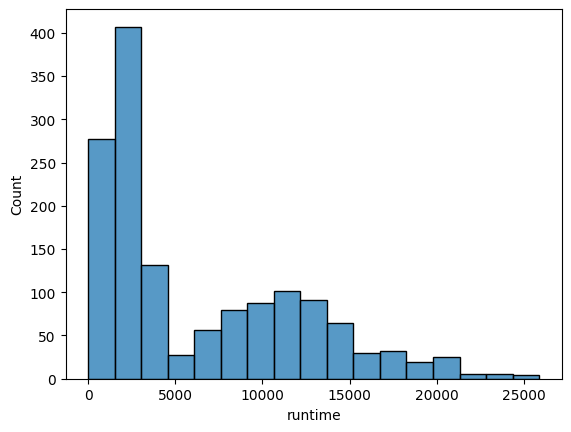

In [917]:
sns.histplot(df["runtime"])

### Create n buckets split with even amounts of runs

In [918]:
sim_times = list(df["runtime"].sort_values())
bin_length = len(sim_times) // N_BUCKETS
CATEGORIES = []
current = 0
for i in range(1,N_BUCKETS):
    CATEGORIES.append(sim_times[bin_length+current])
    current += bin_length
CATEGORIES.append(list(sim_times)[-1])
CATEGORIES

[1602, 2664, 7072, 11969, 25866]

In [919]:
def categorize(seconds):
    global CATEGORIES
    for i in range(len(CATEGORIES)):
        if (seconds <= CATEGORIES[i]):
            return i

def print_categories():
    global CATEGORIES
    for i in range(len(CATEGORIES)):
        print(f"{convert(CATEGORIES[i])}   \t{i}")

In [920]:
runtime_categories = df.apply(lambda row: categorize(row["runtime"]), axis=1)
# df.insert(0, "runtime_ca", runtime_categories)
df["runtime_ca"] = runtime_categories
df.head()

,runtime,sim_time,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,run_max_mem_rss_bytes,area,steps_fire,runtime_ca
0,5475,4503,0.10,600,65.0,2.235,1.00,1934680,560976.0,600,2
1,9737,11382,0.05,600,90.0,4.470,0.90,2470180,1981888.0,600,3
2,501,3937,0.12,600,270.0,2.235,0.95,517424,359488.0,600,0
3,4325,4921,0.10,600,137.0,3.000,1.10,2454040,1053216.0,600,2
4,9008,14997,0.15,600,360.0,4.470,1.00,3919432,648024.0,600,3


26 minutes   	 0
44 minutes   	 1
an hour   	 2
3 hours   	 3
7 hours   	 4
[1602, 2664, 7072, 11969, 25866]


runtime_ca
0    289
4    289
2    288
3    288
1    288
Name: count, dtype: int64

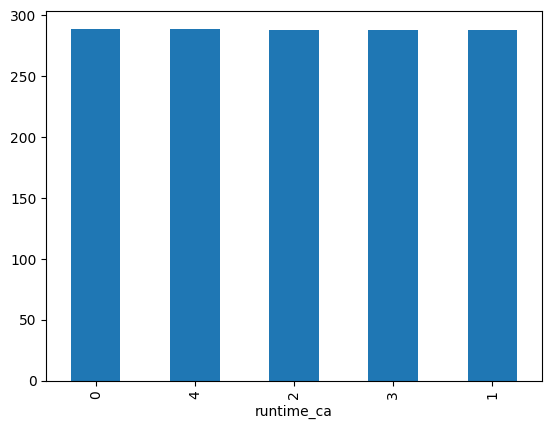

In [921]:
for i in range(len(CATEGORIES)):
    print(convert(CATEGORIES[i]),"  \t",i)
print(CATEGORIES)
df["runtime_ca"].value_counts().plot(kind="bar")
df["runtime_ca"].value_counts()

In [922]:
y = df["runtime_ca"]
X = df.drop(columns=["runtime","runtime_ca"])
X.tail()

,sim_time,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,run_max_mem_rss_bytes,area,steps_fire
1562,4005,0.10,600,60.0,2.235,0.90,401132,294840.0,600
1563,11359,0.05,600,150.0,4.023,1.00,2470680,1981888.0,600
1564,3937,0.07,600,240.0,2.235,0.95,517488,359488.0,600
1565,27251,0.15,600,60.0,4.470,0.90,3920324,648024.0,600
1566,4005,0.10,600,90.0,2.235,0.90,404324,294840.0,600


In [923]:
TEST_RATIO = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO,random_state=42)

# X_train = np.array(X_train)
# X_test = np.array(X_test)
# y_train = np.array(y_train)
# y_test = np.array(y_test)

print(len(X_train), len(X_test), len(y_train), len(y_test))

1153 289 1153 289


# Classification Approaches
- K Means clustering
- Support Vector Machines
- Decision Trees
- Logistic Regression
- Stochastic Gradient Descent
- k Nearest Neighbors
- Random Forest
- Gradient Boosting
- LGBM
- XGB
- GRBT
- Keras neural net

Ensemble Methods
- Voting Classifier (Hard and Soft)


# Principal Component Analysis

In [924]:
from sklearn.preprocessing import StandardScaler


# Standardizing the features
x_tr = StandardScaler().fit_transform(X_train)
x_te = StandardScaler().fit_transform(X_test)
X_train  = x_tr
X_test = x_te


In [925]:
from sklearn.decomposition import PCA

pca = PCA(n_components=N_FEATURES)

principalComponents = pca.fit_transform(x_tr)
# principalComponents = pca.fit_transform(x_te)

columns = []
for i in range(N_FEATURES):
    columns.append('pc'+str(i+1))

principalDf = pd.DataFrame(data = principalComponents
             , columns = columns)
principalDf

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9
0,5.059003,-0.349913,-0.194188,0.115537,0.100735,-0.577014,-0.834581,-2.997792e-17,-0.0
1,3.966041,-0.419386,-0.864955,-0.106402,1.026831,-0.290749,-0.843278,4.031518e-17,0.0
2,0.167789,0.078544,-0.663254,-0.333870,0.345646,1.454306,0.330327,1.508067e-15,-0.0
3,2.080230,-0.217493,-0.521520,-1.636613,0.148159,0.842600,1.751030,-7.146696e-18,0.0
4,0.293975,-0.057179,0.033611,-0.038830,0.870975,0.322254,-0.230805,-1.619690e-18,0.0
...,...,...,...,...,...,...,...,...,...
1148,1.692802,-0.248479,-0.630972,-1.295461,0.105789,0.786478,1.457470,-6.364891e-18,0.0
1149,4.656933,-0.396537,-0.861977,-0.569300,1.058689,-0.259406,-0.184153,-1.122814e-18,0.0
1150,-1.187982,-0.244702,-1.157597,1.167232,-0.113069,0.177412,-0.370383,-2.421467e-19,-0.0
1151,-0.629434,-1.896367,0.880151,-0.923903,-0.018524,0.135344,0.404748,-6.248569e-19,-0.0


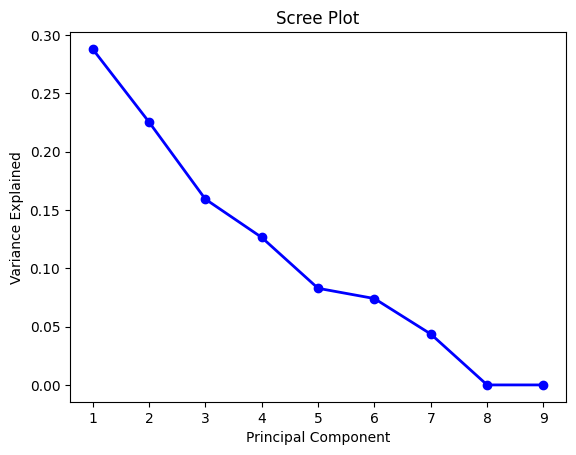

In [926]:
import matplotlib.pyplot as plt
import numpy as np

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [927]:
series = pd.Series([str(round(x)) for x in y_train])
finalDf = principalDf
finalDf['target'] = series

In [928]:
finalDf

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,target
0,5.059003,-0.349913,-0.194188,0.115537,0.100735,-0.577014,-0.834581,-2.997792e-17,-0.0,3
1,3.966041,-0.419386,-0.864955,-0.106402,1.026831,-0.290749,-0.843278,4.031518e-17,0.0,0
2,0.167789,0.078544,-0.663254,-0.333870,0.345646,1.454306,0.330327,1.508067e-15,-0.0,1
3,2.080230,-0.217493,-0.521520,-1.636613,0.148159,0.842600,1.751030,-7.146696e-18,0.0,2
4,0.293975,-0.057179,0.033611,-0.038830,0.870975,0.322254,-0.230805,-1.619690e-18,0.0,1
...,...,...,...,...,...,...,...,...,...,...
1148,1.692802,-0.248479,-0.630972,-1.295461,0.105789,0.786478,1.457470,-6.364891e-18,0.0,1
1149,4.656933,-0.396537,-0.861977,-0.569300,1.058689,-0.259406,-0.184153,-1.122814e-18,0.0,2
1150,-1.187982,-0.244702,-1.157597,1.167232,-0.113069,0.177412,-0.370383,-2.421467e-19,-0.0,2
1151,-0.629434,-1.896367,0.880151,-0.923903,-0.018524,0.135344,0.404748,-6.248569e-19,-0.0,0


Text(0.5, 0, 'PC3')

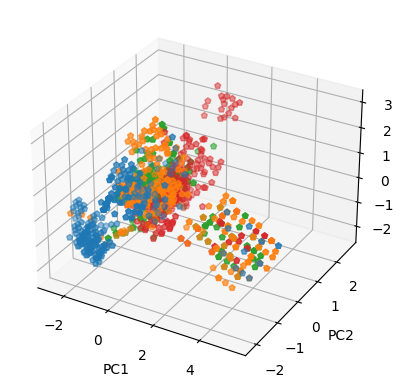

In [929]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

l = ['0','1','2','3']
df_list = []
for item in l:
    df = finalDf.query(f"target == '{item}'")
    df_list.append(df)

for df in df_list:
    ax.scatter(df['pc1'], df['pc2'], df['pc3'],marker='p')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

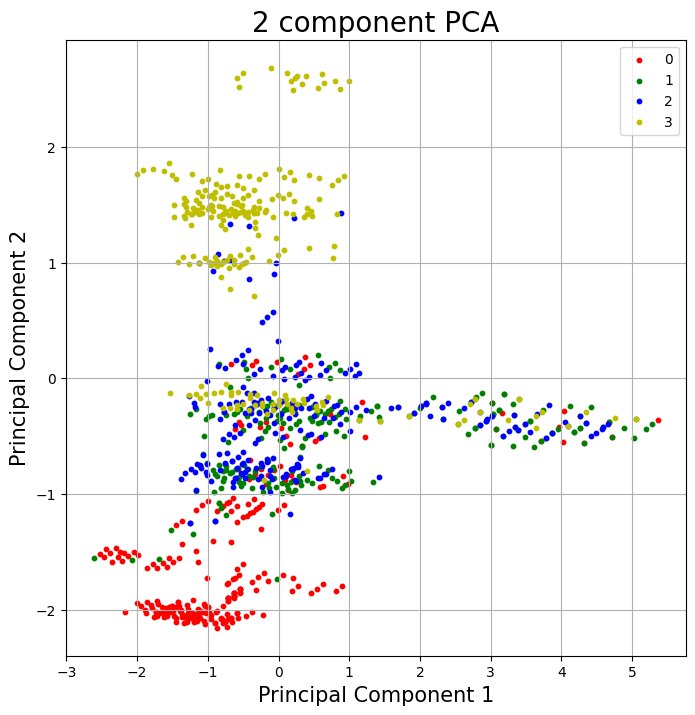

In [930]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['0','1','2','3']
colors = ['r', 'g', 'b', 'y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1']
               , finalDf.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()

# Gather and Split Test/Train Data

In [931]:
# y = finalDf['target']                # Uncomment this if you want PCA as the training data
# X = finalDf.drop(columns=["target"]) # Uncomment this if you want PCA as the training data
X.tail()

,sim_time,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,run_max_mem_rss_bytes,area,steps_fire
1562,4005,0.10,600,60.0,2.235,0.90,401132,294840.0,600
1563,11359,0.05,600,150.0,4.023,1.00,2470680,1981888.0,600
1564,3937,0.07,600,240.0,2.235,0.95,517488,359488.0,600
1565,27251,0.15,600,60.0,4.470,0.90,3920324,648024.0,600
1566,4005,0.10,600,90.0,2.235,0.90,404324,294840.0,600


In [932]:
TEST_RATIO = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO,random_state=42)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train, dtype=np.int32)
y_test = np.array(y_test, dtype=np.int32)

print(len(X_train), len(X_test), len(y_train), len(y_test))

1153 289 1153 289


# Try Different Models from ScikitLearn

## K Means Clustering

In [933]:
from sklearn.cluster import KMeans

# ------ experiment with cluster amount ---------- #
n_clusters = len(CATEGORIES)
# ------ experiment with cluster amount ---------- #

model = KMeans(n_clusters=n_clusters, n_init=10)
model = model.fit(X_train,y_train)

In [934]:
pred["Kmeans"] = model.predict(X_test)
models["Kmeans"] = model

In [935]:
print_score(pred["Kmeans"], y_test)

Mean Squared Error:    5.78201
Mean Absolute Error:   1.85121


In [936]:
accuracy_score(y_true=y_test,y_pred=pred["Kmeans"])

0.23183391003460208

15% is very bad accuracy, something must be wrong with my approach to using K means here but I am not sure so I will try another model. Could be an input data problem but I am skeptical of that

## SVM

In [937]:
from sklearn.svm import SVC
model = SVC(kernel='rbf')
model = model.fit(X_train,y_train)

In [938]:
pred["SVM"] = model.predict(X_test)
models["SVM"] = model
accuracy_score(y_true=y_test,y_pred=pred["SVM"])

0.5224913494809689

## Decision Tree Classifier

In [939]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model = model.fit(X_train, y_train)

In [940]:
pred["DecisionTree"] = model.predict(X_test)
models["DecisionTree"] = model
accuracy_score(y_true=y_test,y_pred=pred["DecisionTree"])

0.5951557093425606

## Logistic Regression

In [941]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=400)
model = model.fit(X_train, y_train)

/root/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [942]:
pred["LogisticRegression"] = model.predict(X_test)
models["LogisticRegression"] = model
accuracy_score(y_true=y_test,y_pred=pred["LogisticRegression"])

0.4532871972318339

## Stochastic Gradient Descent

In [943]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier()
model = model.fit(X_train, y_train)

In [944]:
pred["SGD"] = model.predict(X_test)
models["SGD"] = model
accuracy_score(y_true=y_test,y_pred=pred["SGD"])

0.18685121107266436

## K Nearest Neighbor

In [945]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=len(CATEGORIES))
model = model.fit(X_train, y_train)

In [946]:
pred["kNN"] = model.predict(X_test)
models["kNN"] = model
accuracy_score(y_true=y_test,y_pred=pred["kNN"])

0.6020761245674741

## Random Forest


In [972]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=110, max_features='sqrt',max_depth=7)
model = model.fit(X_train, y_train)
model

RandomForestClassifier(max_depth=7, n_estimators=110)

In [973]:
pred["RandomForest"] = model.predict(X_test)
models["RandomForest"] = model
accuracy_score(y_true=y_test,y_pred=pred["RandomForest"])

0.6366782006920415

## Gradient Boosting

In [974]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(max_depth=3, learning_rate=0.1, n_estimators = 35)
model = model.fit(X_train, y_train)

In [975]:
pred["GradientBoosting"] = model.predict(X_test)
models["GradientBoosting"] = model

accuracy_score(y_true=y_test,y_pred=pred["GradientBoosting"])

0.6505190311418685

## LGBM

In [976]:
# !pip3 install --user lightgbm

In [977]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

model = LGBMClassifier(n_estimators=8)
model.fit(X_train,y_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 1153, number of used features: 7
[LightGBM] [Info] Start training from score -1.569484
[LightGBM] [Info] Start training from score -1.656495
[LightGBM] [Info] Start training from score -1.629588
[LightGBM] [Info] Start training from score -1.573659
[LightGBM] [Info] Start training from score -1.620777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(n_estimators=8)

In [978]:
pred["LGBM"] = model.predict(X_test)
models["LGBM"] = model

accuracy_score(y_true=y_test,y_pred=pred["LGBM"])

0.6505190311418685

## XGB

In [979]:
# !pip3 install --user xgboost

In [980]:
from xgboost.sklearn import XGBClassifier
# ----------------- #
n = 100
# ----------------- #
model = XGBClassifier(n_estimators = n)
model = model.fit(X_train, y_train)

In [981]:
pred["XGB"] = model.predict(X_test)
models["XGB"] = model

accuracy_score(y_true=y_test,y_pred=pred["XGB"])

0.5951557093425606

## Naive Bayes

Naive Bayes model might help

In [982]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model = model.fit(X_train, y_train)

In [983]:
pred["GaussianNB"] = model.predict(X_test)
models["GaussinNB"] = model

accuracy_score(y_true=y_test,y_pred=pred["GaussianNB"])

0.5605536332179931

## Extra Tree Classifier

In [984]:
from sklearn.tree import ExtraTreeClassifier

model = ExtraTreeClassifier(random_state=0)
model = model.fit(X_train, y_train)

In [986]:
pred["Extra tree"] = model.predict(X_test)
models["Extra tree"] = model

accuracy_score(y_true=y_test,y_pred=pred["Extra tree"])

0.6055363321799307

## Scikit-learn's neural nets

### Multi Layer Perceptron

In [987]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(solver='lbfgs',  alpha=1e-5, max_iter=400)

model.fit(X_train, y_train)

/root/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, max_iter=400, solver='lbfgs')

In [988]:
pred["MLP"] = model.predict(X_test)
models["MLP"] = model

accuracy_score(y_true=y_test,y_pred=pred["MLP"])

0.16262975778546712

## Gaussian Process

In [989]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

kernel = 1.0 * RBF(1.0)
model = GaussianProcessClassifier(kernel=kernel)

# This takes a while to run 
model.fit(X_train, y_train)

/root/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/root/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))

Uncomment these

In [990]:
pred["GPC"] = model.predict(X_test)
models["GPC"] = model

accuracy_score(y_true=y_test,y_pred=pred["GPC"])

0.6539792387543253

## Ensemble Learning
voting classifier to predict based on votes from multiple previous classifiers

### Voting Classifier With Hard Voting

In [991]:
from sklearn.ensemble import VotingClassifier

estimators = [
    ('svc',models['SVM']),
    ('lr',models['LogisticRegression']),
    ('rf',models['RandomForest']),
    ('kNN',models['kNN']),
    ('dt',models['DecisionTree']),
    ('sgd',models['SGD']),
    ('XGB',models['XGB']),
    ('gradient',models['GradientBoosting'])
]


voting_clf = VotingClassifier(
    estimators=estimators,
    voting='hard'
)

In [992]:
voting_clf.fit(X_train,y_train)

/root/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('svc', SVC()),
                             ('lr', LogisticRegression(max_iter=400)),
                             ('rf',
                              RandomForestClassifier(max_depth=7,
                                                     n_estimators=110)),
                             ('kNN', KNeighborsClassifier()),
                             ('dt', DecisionTreeClassifier()),
                             ('sgd', SGDClassifier()),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob',
                                            predictor=None, ...)),
                             ('gradient',
                              GradientBoostingClassifier(n_estimators=35))])

In [993]:
pred["Voting"] = model.predict(X_test)
models["Voting"] = model

accuracy_score(y_true=y_test,y_pred=pred["Voting"])

0.6539792387543253

In [994]:
for name, model in estimators:
    print(name.ljust(10),model.predict(X_test[100:110]))

print("voting".ljust(10),voting_clf.predict(X_test[100:110]),"\n")
print("y_test".ljust(10),y_test[100:110])

svc        [0 2 0 2 3 4 3 0 2 0]
lr         [0 1 0 2 3 4 3 0 2 0]
rf         [1 2 0 2 3 3 3 1 1 1]
kNN        [2 2 0 2 3 3 3 2 2 1]
dt         [2 2 0 0 3 3 4 1 1 1]
sgd        [4 4 3 4 3 4 3 4 4 4]
XGB        [2 2 0 2 3 3 4 1 1 1]
gradient   [1 2 0 2 3 3 3 1 1 1]
voting     [1 2 0 2 3 3 3 1 1 1] 

y_test     [1 2 0 2 4 3 2 1 1 1]


### Voting Classifier with Probability Predictions

In [995]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators = [
        ('lr',models['LogisticRegression']),
        ('rf',models['RandomForest']),
        ('kNN',models['kNN']),
        ('XGB',models['XGB']),
        ('gradient',models['GradientBoosting'])
    ],
    voting='soft',
    # weights=[1, 1, 1, 1, 1, 1]
)
voting_clf.fit(X_train,y_train)

/root/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=400)),
                             ('rf',
                              RandomForestClassifier(max_depth=7,
                                                     n_estimators=110)),
                             ('kNN', KNeighborsClassifier()),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_m...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob',
                                            predictor=None, ...)),
                             ('gradient',
                              GradientBoostingClassifier(n_estimators=35))],
                 voting='soft')

In [996]:
pred["SoftVoting"] = model.predict(X_test)
models["SoftVoting"] = model
accuracy_score(y_true=y_test,y_pred=pred["SoftVoting"])

0.6505190311418685

In [997]:
estimators = [
    ('lr',models['LogisticRegression']),
    ('rf',models['RandomForest']),
    ('kNN',models['kNN']),
    ('XGB',models['XGB']),
    ('gradient',models['GradientBoosting'])
]

np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
totals = [0 for i in range(N_BUCKETS)]

for name, model in estimators:
    proba_preds = np.around(model.predict_proba([X_test[100]]),2)
    print(name.ljust(10), proba_preds)
    totals = [a + b for a,b in zip(totals,proba_preds)]

print("voting".ljust(10),voting_clf.predict([X_test[100]]))
print("totals".ljust(10),totals,"\n")
print("y_test".ljust(10),[y_test[100]])


lr         [[0.93 0.01 0.06 0.00 0.00]]
rf         [[0.08 0.56 0.37 0.00 0.00]]
kNN        [[0.00 0.40 0.60 0.00 0.00]]
XGB        [[0.01 0.30 0.69 0.00 0.00]]
gradient   [[0.04 0.63 0.28 0.03 0.03]]
voting     [2]
totals     [array([1.06, 1.90, 2.00, 0.03, 0.03])] 

y_test     [1]


Soft predictor doesn't use all the models cause they can't all give probability predictions

# Hyperparameter tuning for best models above

## Random Forests

In [1006]:
L = list(np.linspace(4,10,5,dtype=np.int32))
L.append(None)
L
param_grid = [{
    'n_estimators': np.linspace(102,110,4,dtype=np.int32),
    'max_features': ["sqrt", "log2", None, 9],
    'max_depth': L,
}]
# {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 110}

In [1007]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier()
grid_search = GridSearchCV(model, param_grid, cv=3,verbose=1)
# grid_search.fit(X_train, y_train)

In [1008]:
# grid_search.best_params_

In [1009]:
from sklearn.ensemble import RandomForestClassifier
# ----------------- #
n = 35
# ----------------- #
model = RandomForestClassifier(n_estimators=110, max_features='sqrt',max_depth=7)
model = model.fit(X_train, y_train)

In [1010]:
pred["RandomForest"] = model.predict(X_test)
models["RandomForest"] = model
accuracy_score(y_true=y_test,y_pred=pred["RandomForest"])

0.6366782006920415

In [716]:
# model.get_params()

From this grid search testing, I found the best parameters to give to the random forest classifier, getting a new best of 74% accuracy!

## GradientBoosting

In [717]:
param_grid = [{
    'n_estimators': [34,35],
    'max_depth': [3,4,5,8,9,10],
    'learning_rate': [0.1],  
}]

In [718]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

model = GradientBoostingClassifier()
grid_search = GridSearchCV(model, param_grid, cv=3,verbose=1)
# grid_search.fit(X_train, y_train)

In [719]:
# grid_search.best_params_

In [720]:
# pred["GradientBoosting"] = m.predict(X_test)
# models["GradientBoosting"] = model

# accuracy_score(y_true=y_test,y_pred=pred["GradientBoosting"])

# Custom Neural Network with Keras

In [1054]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
model = Sequential([
    Dense(24, input_dim = (N_FEATURES), activation = 'relu'),
    Dense(24, activation = 'relu'),
    Dense(24, activation = 'relu'),
    Dense(24, activation = 'relu'),
    Dense(24, activation = 'relu'),
    Dense(N_BUCKETS, activation = 'sigmoid'),
])

In [1055]:
def convert_label(n):
    global N_BUCKETS
    res = np.zeros(N_BUCKETS)
    res[n] = 1
    return res
y_train_ml = np.array([convert_label(i) for i in y_train])
y_test_ml = np.array([convert_label(i) for i in y_test])

In [1056]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_74 (Dense)            (None, 24)                240       
                                                                 
 dense_75 (Dense)            (None, 24)                600       
                                                                 
 dense_76 (Dense)            (None, 24)                600       
                                                                 
 dense_77 (Dense)            (None, 24)                600       
                                                                 
 dense_78 (Dense)            (None, 24)                600       
                                                                 
 dense_79 (Dense)            (None, 5)                 125       
                                                                 
Total params: 2,765
Trainable params: 2,765
Non-train

In [1057]:
history = model.fit(X_train, y_train_ml, epochs=150, batch_size=100, verbose = 1)

Epoch 1/150
12/12 [==============================] - 0s 666us/step - loss: 11980.8555 - accuracy: 0.1873
Epoch 2/150
12/12 [==============================] - 0s 704us/step - loss: 3814.7957 - accuracy: 0.2645
Epoch 3/150
12/12 [==============================] - 0s 641us/step - loss: 1080.0369 - accuracy: 0.3157
Epoch 4/150
12/12 [==============================] - 0s 695us/step - loss: 447.3986 - accuracy: 0.3174
Epoch 5/150
12/12 [==============================] - 0s 756us/step - loss: 252.3257 - accuracy: 0.4042
Epoch 6/150
12/12 [==============================] - 0s 672us/step - loss: 307.8982 - accuracy: 0.3894
Epoch 7/150
12/12 [==============================] - 0s 835us/step - loss: 221.8804 - accuracy: 0.4120
Epoch 8/150
12/12 [==============================] - 0s 800us/step - loss: 237.0421 - accuracy: 0.4389
Epoch 9/150
12/12 [==============================] - 0s 770us/step - loss: 223.6707 - accuracy: 0.4094
Epoch 10/150
12/12 [==============================] - 0s 769us/step -

are we overfitting? Lets see

In [1058]:
scores = model.evaluate(X_train, y_train_ml)
print(f'{model.metrics_names[1]} : {round(scores[1]*100, 2)} %')

37/37 [==============================] - 0s 423us/step - loss: 63.7309 - accuracy: 0.5108
accuracy : 51.08 %


In [1059]:
scores = model.evaluate(X_test, y_test_ml)
print(f'{model.metrics_names[1]} : {round(scores[1]*100, 2)} %')

10/10 [==============================] - 0s 591us/step - loss: 58.1406 - accuracy: 0.5363
accuracy : 53.63 %


In [1063]:
prediction_raw = model.predict(X_test)
pred["Keras"] = []
for i in prediction_raw:
    pred["Keras"].append(np.argmax(i))

accuracy_score(pred["Keras"], y_test)

10/10 [==============================] - 0s 665us/step


0.3217993079584775

In [1069]:
prediction_raw

array([[0.00, 1.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 1.00, 0.00, 0.00, 0.00],
       ...,
       [0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00],
       [0.00, 0.00, 0.00, 0.00, 0.00]], dtype=float32)

In [1027]:
models["Keras"] = model

### Plot the accuracy with time

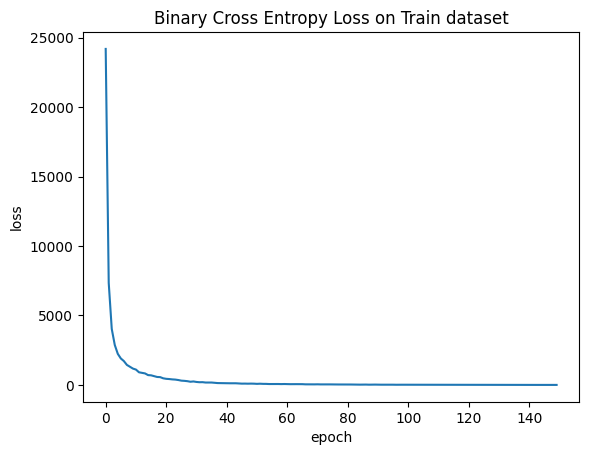

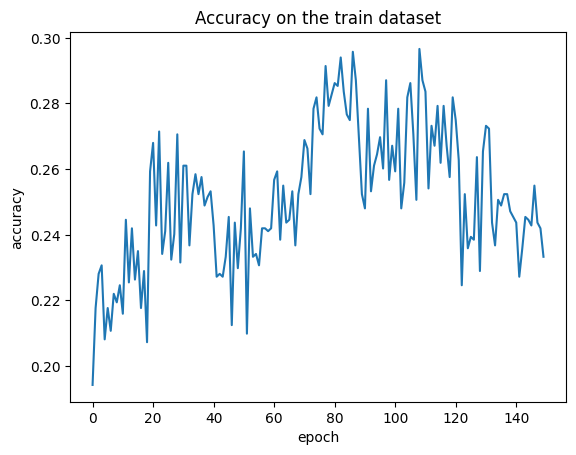

In [1028]:
# Plotting loss
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy Loss on Train dataset')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plotting accuracy metric
plt.plot(history.history['accuracy'])
plt.title('Accuracy on the train dataset')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

Neural net is still work in progress

# Compare Models

Put the accuracy and losses of each model against each other and sort so the best models are on top

In [1029]:
# compare = pd.DataFrame(pred)
compare = pd.DataFrame({
    "name":pred.keys(), 
    "accuracy":np.nan,
    "mse":np.nan,
})
compare = compare.set_index("name")

In [1030]:
compare["accuracy"] = compare.apply(lambda row: accuracy_score(y_pred=pred[row.name],y_true=y_test)*100,axis=1)
compare["mse"] = compare.apply(lambda row: mean_squared_error(y_pred=pred[row.name],y_true=y_test),axis=1)
compare["mean absolute"] = compare.apply(lambda row: mean_absolute_error(y_pred=pred[row.name],y_true=y_test),axis=1)

### So how do the models stack up to each other?

In [1031]:
compare.sort_values(by='accuracy',ascending=False)

,accuracy,mse,mean absolute
name,,,
Voting,65.397924,0.456747,0.380623
GPC,65.397924,0.456747,0.380623
SoftVoting,65.051903,0.449827,0.380623
GradientBoosting,65.051903,0.449827,0.380623
LGBM,65.051903,0.470588,0.387543
Kmeans,63.667820,0.474048,0.397924
keras,63.667820,0.474048,0.397924
RandomForest,63.667820,0.474048,0.397924
Extra tree,60.553633,0.605536,0.460208


so Kmeans is pretty bad, Random Forest, Voting Classifier, GPC, LGBM, and Gradient Boosting are some that appear to be the best

the voting ensemble also does well, just about matching the performance of any one other model. I hoped it would exceed the individuals but it has not yet

In [1004]:
print_categories()

26 minutes   	0
44 minutes   	1
an hour   	2
3 hours   	3
7 hours   	4


For reference, these are the groupings that were decided at the top of the notebook, It is easy to change these out for more user friendly intervals or add more or less (keeping in mind more categories means worse accuracy). I chose these weird intervals because it splits up the training data evenly so there is the same amount of samples in each bucket.

"26 minutes" means that any run between 0 sec and 26 min falls into there, and then 44 minutes would be any run between 26 and 44 min. Since removing outliers, the highest runtime in the dataset is 7 hours

# Save Models

In [1005]:
import pickle
m = {
    'GradientBoosting': models['GradientBoosting'],
    'RandomForest': models['RandomForest'],
    'MLP': models['MLP'],
    'Voting':models['Voting']
}

with open('models.pkl', 'wb') as file:
    pickle.dump(m, file)

This is useful for putting the model into a place to use for inerencing on new data